In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import jupyter_black
import warnings

warnings.filterwarnings("ignore")

jupyter_black.load()
pd.set_option("display.max_columns", None)

# Exploratory data analysis using top 30 features

In [49]:
X = pd.read_csv("../data/X_all_features.csv")
y = pd.read_csv("../data/labels.csv")
feature_importance = pd.read_csv("../data/forest_importances.csv")

In [50]:
feature_importance[-30:].sort_values(by="Importance", ascending=False).head()

,Feature,Importance
108,GENHLTH,0.038351
107,_RFHLTH,0.034585
106,EMPLOY1,0.029818
105,_AGE80,0.026314
104,_AGE65YR,0.025305


In [51]:
# select top 30 features
feature_importance = (
    feature_importance[-30:].sort_values(by="Importance", ascending=False).copy()
)

In [52]:
X = X[feature_importance["Feature"].to_list()]
X.shape

(77266, 30)

In [53]:
# continuous variables, pre-feature selection
continuous = [
    "GRENDAY_",
    "MENTHLTH",
    "ORNGDAY_",
    "HTIN4",
    "WTKG3",
    "FC60_",
    "CHILDREN",
    "MAXVO2_",
    "PHYSHLTH",
    "_VEGESUM",
    "_DRNKWEK",
    "STRFREQ_",
    "VEGEDA1_",
    "VEGETAB1",
    "STRENGTH",
    "_BMI5",
    "DROCDY3_",
    "BEANDAY_",
    "ALCDAY5",
    "FRUIT1",
]

continuous = [col for col in X.columns if col in continuous]

categorical = [col for col in X.columns if col not in continuous]

In [54]:
X.shape

(77266, 30)

## Analyze correlations between continuous features

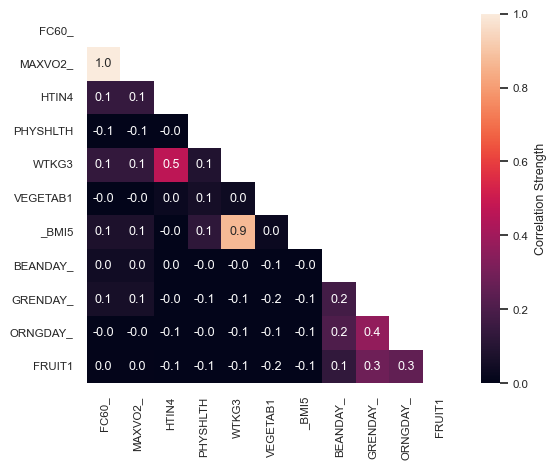

In [124]:
sns.set(font_scale=0.75)
corr = X[continuous].corr()
mask = np.zeros_like(corr, dtype=bool)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    ax1 = sns.heatmap(
        corr,
        vmax=1,
        vmin=0,
        square=True,
        cbar_kws={"label": "Correlation Strength"},
        annot=True,
        fmt=".1f",
        mask=mask,
    )
plt.show()

If any pair of features has a correlation coefficient greater than 0.5, we can try excluding the features with the lower ranked importance (as determined by ExtraTrees)

In [41]:
high_corr_pairs = [
    (col1, col2)
    for col1 in corr.columns
    for col2 in corr.columns
    if col1 != col2 and abs(corr.loc[col1, col2]) > 0.5
]

In [42]:
high_corr_pairs

[('FC60_', 'MAXVO2_'),
 ('MAXVO2_', 'FC60_'),
 ('WTKG3', '_BMI5'),
 ('_BMI5', 'WTKG3')]

In [46]:
feature_importance[
    feature_importance["Feature"].isin(["FC60_", "MAXVO2_", "WTKG3", "_BMI5"])
]

,Feature,Importance
100,FC60_,0.021040
99,MAXVO2_,0.020835
85,WTKG3,0.011722
83,_BMI5,0.011431


MAXVO2_ (Estimated Age-Gender Specific Maximum Oxygen Consumption) and FC60_ (Estimated Functional Capacity, which is a measure of the ratio of the rate of energy expended during an activity to the rate of energy expended at rest) are highly correlated, as are WTKG3 (Reported weight in kilograms) and _BMI5 (Body Mass Index). BMI5 was calculated from WTKG3/(HTM4*HTM4), so it is logical that these two are correlated. 

We may wish to drop MAXVO2_, \_BMI5, which are lower-ranked in terms of feature importance than FC60_ and WTKG3 respectively. 

In [59]:
categorical

['GENHLTH',
 '_RFHLTH',
 'EMPLOY1',
 '_AGE80',
 '_AGE65YR',
 'BPHIGH4',
 '_RFCHOL',
 '_RFHYPE5',
 '_VEGLT1',
 'TOLDHI2',
 'DIFFWALK',
 'SEX',
 '_AGE_G',
 'CVDSTRK3',
 'QLACTLM2',
 '_RFBMI5',
 'PNEUVAC3',
 'CHCCOPD1',
 'DIABETE3']

In [78]:
from itertools import combinations

# Generate all possible pairs
all_pairs = list(combinations(categorical, 2))

# Print the result
len(all_pairs)

171

In [105]:
# https://www.kaggle.com/code/chrisbss1/cramer-s-v-correlation-matrix
from scipy.stats import chi2_contingency
import numpy as np


def cramers_V(var1, var2):
    crosstab = np.array(
        pd.crosstab(var1, var2, rownames=None, colnames=None)
    )  # Cross table building
    stat = chi2_contingency(crosstab)[
        0
    ]  # Keeping of the test statistic of the Chi2 test
    obs = np.sum(crosstab)  # Number of observations
    mini = (
        min(crosstab.shape) - 1
    )  # Take the minimum value between the columns and the rows of the cross table
    return np.sqrt(stat / (obs * mini))


rows = []

for var1 in categorical:
    col = []
    for var2 in categorical:
        cramers = cramers_V(X[var1], X[var2])  # Cramer's V test
        col.append(round(cramers, 2))  # Keeping of the rounded value of the Cramer's V
    rows.append(col)

cramers_results = np.array(rows)
df = pd.DataFrame(cramers_results, columns=categorical, index=categorical)

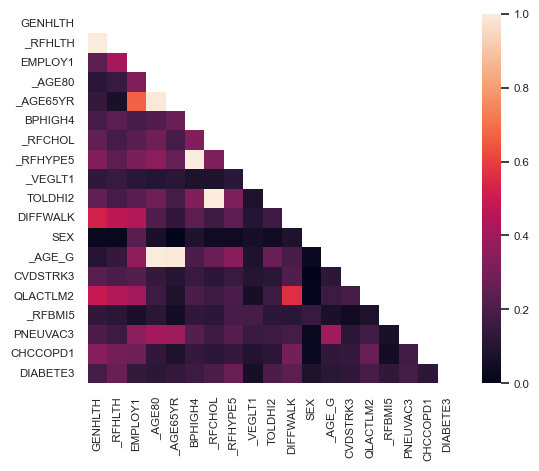

In [119]:
mask = np.zeros_like(df, dtype=bool)
mask[np.triu_indices_from(mask)] = True


with sns.axes_style("white"):
    ax = sns.heatmap(df, mask=mask, vmin=0.0, vmax=1, square=True)

plt.show()

Some feature pairs are highly associated, like _RFCHOL (Adults who have had their cholesterol checked and have been told by a doctor, nurse, or other health professional
that it was high) and TOLDHI2 (Have you EVER been told by a doctor, nurse or other health professional that your blood cholesterol is high?). As with highly correlated numeric features, we may wish to exclude the lower-ranked feature in associated features pairs. 

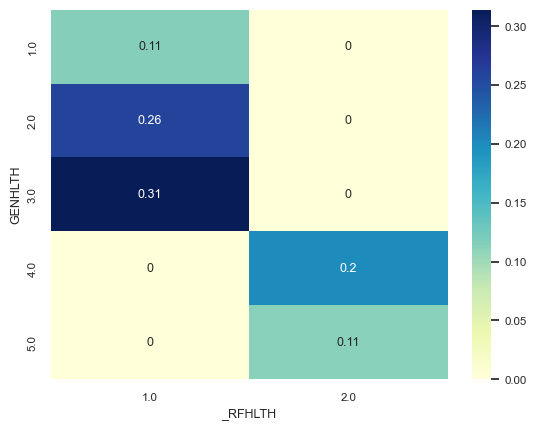

In [114]:
contingency_table = pd.crosstab(X["GENHLTH"], X["_RFHLTH"], normalize=True)
chi2, p, _, _ = chi2_contingency(contingency_table)
sns.heatmap(contingency_table, annot=True, cmap="YlGnBu")
plt.show()

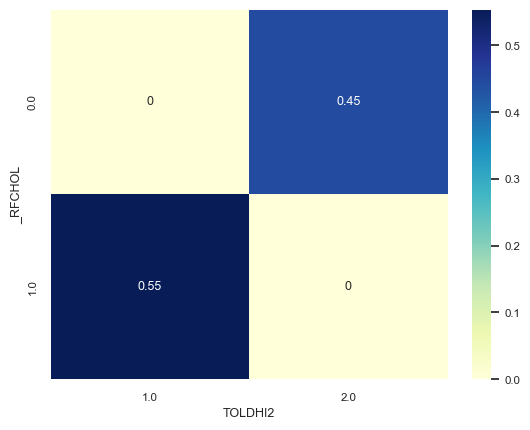

In [111]:
contingency_table = pd.crosstab(X["_RFCHOL"], X["TOLDHI2"], normalize=True)
chi2, p, _, _ = chi2_contingency(contingency_table)
sns.heatmap(contingency_table, annot=True, cmap="YlGnBu")
plt.show()

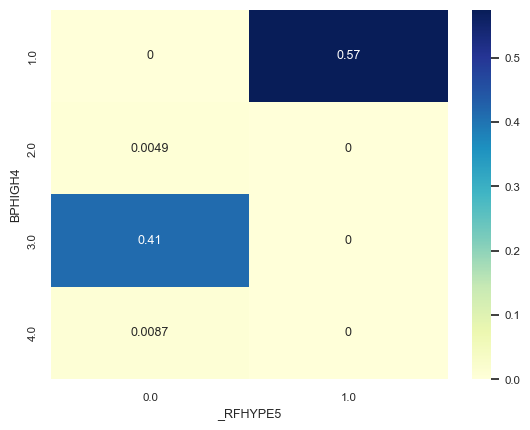

In [113]:
contingency_table = pd.crosstab(X["BPHIGH4"], X["_RFHYPE5"], normalize=True)
chi2, p, _, _ = chi2_contingency(contingency_table)
sns.heatmap(contingency_table, annot=True, cmap="YlGnBu")
plt.show()

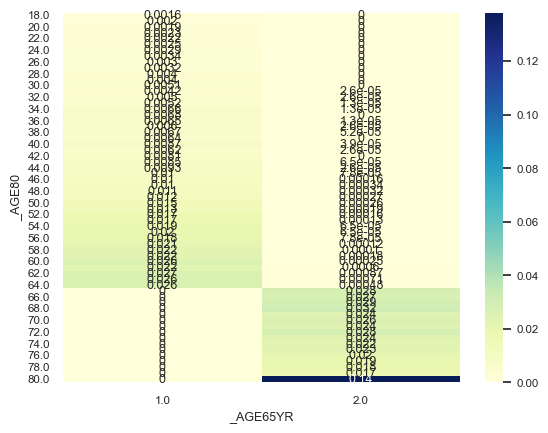

In [115]:
contingency_table = pd.crosstab(X["_AGE80"], X["_AGE65YR"], normalize=True)
chi2, p, _, _ = chi2_contingency(contingency_table)
sns.heatmap(contingency_table, annot=True, cmap="YlGnBu")
plt.show()

We may want to consider how our final  models perform with and without associated categorical variables. 